
### Laboratorio 7 — Monte Carlo con Aproximación de Funciones (CartPole-v1)

Este notebook implementa **tres agentes** de Aprendizaje por Refuerzo con **Aproximación de Funciones** para el entorno **CartPole-v1** de Gymnasium, utilizando **Monte Carlo (MC)** como mecanismo de actualización:

1. **Árbol de Decisión** (regresión)  
2. **Random Forest** (ensamble de árboles)  
3. **Red Neuronal Feed-Forward** (PyTorch)

### Librerías

In [1]:
import math
import random
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Any
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

# Gymnasium
import gymnasium as gym

# Scikit-learn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


### Utilidades y Representación de Características

Representamos \(Q(s,a)\) con un modelo de regresión que recibe como entrada el estado continuo (escalado) y la acción codificada one-hot, y devuelve el valor estimado \(Q(s,a)\).

Para árboles y random forest usamos scikit-learn. Para la red, usamos un MLP en PyTorch.

In [2]:

class FeatureCoder:
    """Escala estados y codifica acciones como one-hot, luego concatena [state_scaled || action_onehot]."""
    def __init__(self, n_actions: int):
        self.state_scaler = StandardScaler()
        self.action_enc = OneHotEncoder(sparse_output=False, categories='auto')
        self.n_actions = n_actions
        self._fitted = False

    def fit(self, states: np.ndarray, actions: np.ndarray):
        self.state_scaler.fit(states)
        self.action_enc.fit(actions.reshape(-1, 1))
        self._fitted = True

    def transform(self, states: np.ndarray, actions: np.ndarray) -> np.ndarray:
        assert self._fitted, "FeatureCoder no está ajustado. Llama primero a fit."
        S = self.state_scaler.transform(states)
        A = self.action_enc.transform(actions.reshape(-1, 1))
        return np.hstack([S, A])

    def fit_transform(self, states: np.ndarray, actions: np.ndarray) -> np.ndarray:
        self.fit(states, actions)
        return self.transform(states, actions)


### Generación de Episodios y Retornos (Every-Visit MC)

- Generamos episodios con política \(\epsilon\)-greedy.  
- Calculamos el retorno desde cada tiempo: \(G_t = \sum_{k=t}^{T-1} \gamma^{k-t} r_{k+1}\).  
- Every-visit: entrenamos con todas las visitas de \((s_t, a_t)\).

In [3]:

@dataclass
class EpisodeStep:
    state: np.ndarray
    action: int
    reward: float

def epsilon_greedy(q_values: np.ndarray, epsilon: float) -> int:
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_values))
    return int(np.argmax(q_values))

def compute_returns(rewards: List[float], gamma: float) -> List[float]:
    G = 0.0
    returns = [0.0] * len(rewards)
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns

def rollout_episode(env, q_predict_fn, epsilon: float, gamma: float, max_steps: int = 500) -> List[EpisodeStep]:
    state, _ = env.reset(seed=SEED)
    steps: List[EpisodeStep] = []
    for t in range(max_steps):
        # Calcular Q(s, ·) con el aproximador
        q_s = q_predict_fn(state)  
        action = epsilon_greedy(q_s, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        steps.append(EpisodeStep(state=state, action=action, reward=reward))
        state = next_state
        if terminated or truncated:
            break
    return steps


### Interfaz de Agente con Aproximador \(Q(s,a)\)

Creamos una clase base para manejar:
- Predicción de \(Q(s,a)\) en lote para todas las acciones.
- Buffer de experiencias MC \((s,a,G)\).
- Entrenamiento por bloques (refit periódico para modelos de sklearn).

In [4]:

class BaseQFunction:
    def __init__(self, n_actions: int, state_dim: int):
        self.n_actions = n_actions
        self.state_dim = state_dim
        self.feature_coder = FeatureCoder(n_actions=n_actions)
        self._is_fitted = False
        # replay/MC buffer
        self._S = []
        self._A = []
        self._G = []

    def add_mc_batch(self, states: np.ndarray, actions: np.ndarray, returns: np.ndarray):
        self._S.append(states)
        self._A.append(actions)
        self._G.append(returns)

    def _stack_buffer(self):
        if not self._S:
            return None, None
        S = np.vstack(self._S)
        A = np.concatenate(self._A).astype(int)
        G = np.concatenate(self._G).astype(float)
        return S, A, G

    def predict_q(self, state: np.ndarray) -> np.ndarray:
        """Devuelve Q(s, ·) como vector de tamaño n_actions."""
        raise NotImplementedError

    def train_from_buffer(self):
        """Entrena/refit a partir de todo el buffer acumulado."""
        raise NotImplementedError



### Agente con Árbol de Decisión (Regresión)

- Modelo: DecisionTreeRegressor
- Entrenamiento: refit sobre todo el buffer acumulado cada cierto número de episodios.

In [5]:

class DecisionTreeQ(BaseQFunction):
    def __init__(self, n_actions: int, state_dim: int, **tree_kwargs):
        super().__init__(n_actions, state_dim)
        self.model = DecisionTreeRegressor(**tree_kwargs)

    def predict_q(self, state: np.ndarray) -> np.ndarray:
        if not self._is_fitted:
            return np.zeros(self.n_actions, dtype=float)
        states = np.tile(state, (self.n_actions, 1))
        actions = np.arange(self.n_actions)
        X = self.feature_coder.transform(states, actions)
        preds = self.model.predict(X)
        return preds.astype(float)

    def train_from_buffer(self):
        data = self._stack_buffer()
        if data[0] is None:
            return
        S, A, G = data
        if not self._is_fitted:
            X = self.feature_coder.fit_transform(S, A)
        else:
            X = self.feature_coder.transform(S, A)
        y = G
        self.model.fit(X, y)
        self._is_fitted = True



### Agente con Random Forest

- Modelo: RandomForestRegressor  
- Entrenamiento: refit sobre buffer acumulado (mejor estabilidad que un árbol único).

In [6]:

class RandomForestQ(BaseQFunction):
    def __init__(self, n_actions: int, state_dim: int, **rf_kwargs):
        super().__init__(n_actions, state_dim)
        self.model = RandomForestRegressor(**rf_kwargs)

    def predict_q(self, state: np.ndarray) -> np.ndarray:
        if not self._is_fitted:
            return np.zeros(self.n_actions, dtype=float)
        states = np.tile(state, (self.n_actions, 1))
        actions = np.arange(self.n_actions)
        X = self.feature_coder.transform(states, actions)
        preds = self.model.predict(X)
        return preds.astype(float)

    def train_from_buffer(self):
        data = self._stack_buffer()
        if data[0] is None:
            return
        S, A, G = data
        if not self._is_fitted:
            X = self.feature_coder.fit_transform(S, A)
        else:
            X = self.feature_coder.transform(S, A)
        y = G
        self.model.fit(X, y)
        self._is_fitted = True



### Agente con Red Neuronal (MLP)

- Arquitectura simple (2–3 capas ocultas).  
- Pérdida MSE contra los retornos MC como *targets*.  
- Entrenamiento por minibatches a partir del buffer acumulado.

In [7]:

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: List[int] = [128, 128]):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU())
            last = h
        layers.append(nn.Linear(last, 1))  # salida escalar Q(s,a)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class NeuralNetQ(BaseQFunction):
    def __init__(self, n_actions: int, state_dim: int, hidden=[128,128], lr=1e-3, device=None):
        super().__init__(n_actions, state_dim)
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        # in_dim = state_dim + n_actions (one-hot)
        self.model = MLP(in_dim=state_dim + n_actions, hidden=hidden).to(self.device)
        self.opt = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def predict_q(self, state: np.ndarray) -> np.ndarray:
        if not self._is_fitted:
            return np.zeros(self.n_actions, dtype=float)
        states = np.tile(state, (self.n_actions, 1))
        actions = np.arange(self.n_actions)
        X = self.feature_coder.transform(states, actions)
        X_t = torch.tensor(X, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            q = self.model(X_t).squeeze(-1).cpu().numpy()
        return q.astype(float)

    def train_from_buffer(self, epochs: int = 5, batch_size: int = 256):
        data = self._stack_buffer()
        if data[0] is None:
            return
        S, A, G = data
        if not self._is_fitted:
            X = self.feature_coder.fit_transform(S, A)
            self._is_fitted = True
        else:
            X = self.feature_coder.transform(S, A)
        y = G.reshape(-1, 1)
        X_t = torch.tensor(X, dtype=torch.float32, device=self.device)
        y_t = torch.tensor(y, dtype=torch.float32, device=self.device)
        ds = torch.utils.data.TensorDataset(X_t, y_t)
        dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)

        self.model.train()
        for _ in range(epochs):
            for xb, yb in dl:
                pred = self.model(xb)
                loss = self.loss_fn(pred, yb)
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()



### Bucle de Entrenamiento MC y Evaluación

- Entrenamiento: generamos episodios, computamos retornos y agregamos \((s,a,G)\) al buffer.  
- Reajustamos el modelo cada update_freq episodios.  
- Evaluación periódica (\(\epsilon=0\)) para medir retorno promedio y tasa de éxito (episodios con 500 pasos).


In [8]:

@dataclass
class TrainConfig:
    episodes: int = 500
    gamma: float = 0.99
    epsilon_start: float = 1.0
    epsilon_end: float = 0.05
    epsilon_decay: int = 300  
    update_freq: int = 5       
    eval_every: int = 20
    eval_episodes: int = 10
    max_steps: int = 500

def linear_decay(ep, start, end, decay):
    frac = min(1.0, ep / decay)
    return start + (end - start) * frac

def evaluate_agent(env, q_predict_fn, cfg: TrainConfig) -> Tuple[float, float]:
    returns = []
    successes = 0
    for _ in range(cfg.eval_episodes):
        state, _ = env.reset(seed=np.random.randint(0, 10_000))
        total_r = 0.0
        for t in range(cfg.max_steps):
            q_s = q_predict_fn(state)
            action = int(np.argmax(q_s))  
            state, reward, terminated, truncated, _ = env.step(action)
            total_r += reward
            if terminated or truncated:
                if t+1 >= cfg.max_steps:
                    successes += 1
                break
        returns.append(total_r)
    return float(np.mean(returns)), successes / cfg.eval_episodes

def train_mc_agent(agent: BaseQFunction, cfg: TrainConfig, env_name: str = "CartPole-v1") -> Dict[str, List[float]]:
    env = gym.make(env_name)
    metrics = {
        "episode_return": [],
        "eval_return": [],
        "eval_success": [],
        "epsilon": []
    }
    for ep in range(1, cfg.episodes + 1):
        epsilon = linear_decay(ep, cfg.epsilon_start, cfg.epsilon_end, cfg.epsilon_decay)
        steps = rollout_episode(
            env=env,
            q_predict_fn=agent.predict_q,
            epsilon=epsilon,
            gamma=cfg.gamma,
            max_steps=cfg.max_steps
        )
        rewards = [s.reward for s in steps]
        Gs = compute_returns(rewards, cfg.gamma)

        states = np.array([s.state for s in steps], dtype=np.float32)
        actions = np.array([s.action for s in steps], dtype=int)
        returns = np.array(Gs, dtype=np.float32)

        agent.add_mc_batch(states, actions, returns)

        if ep % cfg.update_freq == 0:
            # entrenar/refit
            if isinstance(agent, NeuralNetQ):
                agent.train_from_buffer(epochs=5, batch_size=256)
            else:
                agent.train_from_buffer()

        metrics["episode_return"].append(sum(rewards))
        metrics["epsilon"].append(epsilon)

        if ep % cfg.eval_every == 0:
            avg_ret, succ = evaluate_agent(env, agent.predict_q, cfg)
            metrics["eval_return"].append(avg_ret)
            metrics["eval_success"].append(succ)
            print(f"[Ep {ep}] EvalReturn={avg_ret:.1f}  Success={succ*100:.0f}%  Eps={epsilon:.2f}")

    env.close()
    return metrics



### Entrenar y Comparar

In [9]:

cfg = TrainConfig(
    episodes=400,      
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=300,
    update_freq=5,
    eval_every=20,
    eval_episodes=10,
    max_steps=500,
)

state_dim = 4
n_actions = 2

# 1) Árbol de Decisión
tree_agent = DecisionTreeQ(n_actions=n_actions, state_dim=state_dim, max_depth=30, min_samples_leaf=2)
metrics_tree = train_mc_agent(tree_agent, cfg)

# 2) Random Forest
rf_agent = RandomForestQ(n_actions=n_actions, state_dim=state_dim, n_estimators=120, max_depth=30, n_jobs=-1)
metrics_rf = train_mc_agent(rf_agent, cfg)

# 3) Red Neuronal
nn_agent = NeuralNetQ(n_actions=n_actions, state_dim=state_dim, hidden=[128,128], lr=1e-3)
metrics_nn = train_mc_agent(nn_agent, cfg)


[Ep 20] EvalReturn=46.1  Success=0%  Eps=0.94
[Ep 40] EvalReturn=22.1  Success=0%  Eps=0.87
[Ep 60] EvalReturn=60.0  Success=0%  Eps=0.81
[Ep 80] EvalReturn=42.5  Success=0%  Eps=0.75
[Ep 100] EvalReturn=42.9  Success=0%  Eps=0.68
[Ep 120] EvalReturn=111.1  Success=0%  Eps=0.62
[Ep 140] EvalReturn=92.1  Success=0%  Eps=0.56
[Ep 160] EvalReturn=96.2  Success=0%  Eps=0.49
[Ep 180] EvalReturn=96.3  Success=0%  Eps=0.43
[Ep 200] EvalReturn=71.0  Success=0%  Eps=0.37
[Ep 220] EvalReturn=118.7  Success=0%  Eps=0.30
[Ep 240] EvalReturn=116.5  Success=0%  Eps=0.24
[Ep 260] EvalReturn=103.0  Success=0%  Eps=0.18
[Ep 280] EvalReturn=90.9  Success=0%  Eps=0.11
[Ep 300] EvalReturn=60.2  Success=0%  Eps=0.05
[Ep 320] EvalReturn=80.4  Success=0%  Eps=0.05
[Ep 340] EvalReturn=89.7  Success=0%  Eps=0.05
[Ep 360] EvalReturn=57.7  Success=0%  Eps=0.05
[Ep 380] EvalReturn=88.1  Success=0%  Eps=0.05
[Ep 400] EvalReturn=59.2  Success=0%  Eps=0.05
[Ep 20] EvalReturn=215.8  Success=0%  Eps=0.94
[Ep 40] EvalR


### Resultados: Curvas de Desempeño
Mostramos la evolución del retorno por episodio y la evaluación periódica.


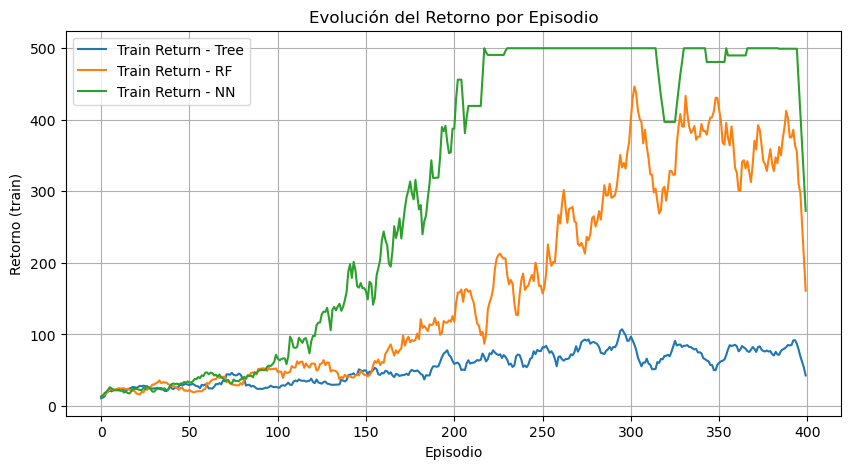

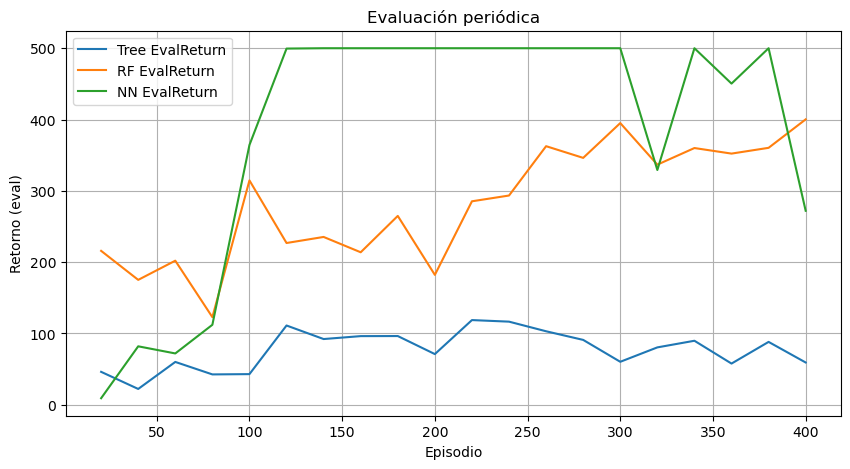

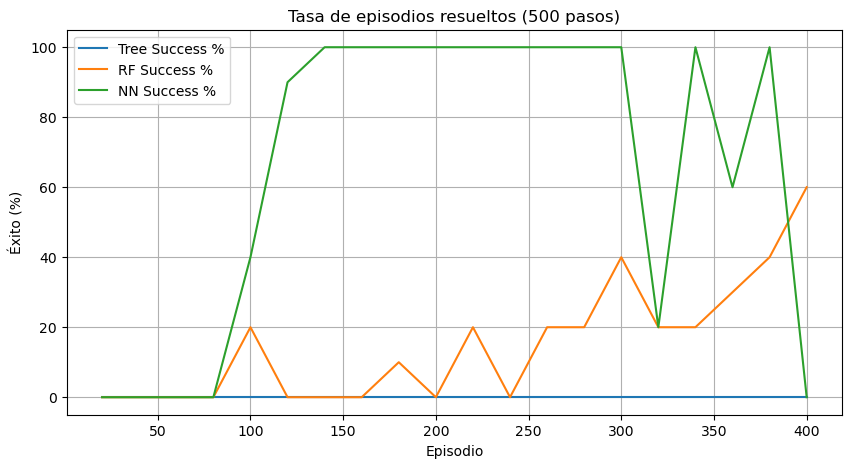

In [10]:

def smooth(x, k=11):
    if len(x) < k:
        return np.array(x)
    w = np.ones(k)/k
    return np.convolve(x, w, mode='same')

plt.figure(figsize=(10,5))
plt.plot(smooth(metrics_tree["episode_return"]), label="Train Return - Tree")
plt.plot(smooth(metrics_rf["episode_return"]), label="Train Return - RF")
plt.plot(smooth(metrics_nn["episode_return"]), label="Train Return - NN")
plt.xlabel("Episodio"); plt.ylabel("Retorno (train)"); plt.title("Evolución del Retorno por Episodio")
plt.legend(); plt.grid(True)
plt.show()

# Evaluación
def plot_eval(metrics, label_prefix):
    xs = np.arange(1, len(metrics["eval_return"])+1) * cfg.eval_every
    plt.plot(xs, metrics["eval_return"], label=f"{label_prefix} EvalReturn")
    plt.scatter(xs, metrics["eval_return"], s=10)
    plt.twinx()

plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(metrics_tree["eval_return"])+1) * cfg.eval_every, metrics_tree["eval_return"], label="Tree EvalReturn")
plt.plot(np.arange(1, len(metrics_rf["eval_return"])+1) * cfg.eval_every, metrics_rf["eval_return"], label="RF EvalReturn")
plt.plot(np.arange(1, len(metrics_nn["eval_return"])+1) * cfg.eval_every, metrics_nn["eval_return"], label="NN EvalReturn")
plt.xlabel("Episodio"); plt.ylabel("Retorno (eval)"); plt.title("Evaluación periódica")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(metrics_tree["eval_success"])+1) * cfg.eval_every, np.array(metrics_tree["eval_success"])*100, label="Tree Success %")
plt.plot(np.arange(1, len(metrics_rf["eval_success"])+1) * cfg.eval_every, np.array(metrics_rf["eval_success"])*100, label="RF Success %")
plt.plot(np.arange(1, len(metrics_nn["eval_success"])+1) * cfg.eval_every, np.array(metrics_nn["eval_success"])*100, label="NN Success %")
plt.xlabel("Episodio"); plt.ylabel("Éxito (%)"); plt.title("Tasa de episodios resueltos (500 pasos)")
plt.legend(); plt.grid(True)
plt.show()



### Resumen Numérico
Promedios de las últimas evaluaciones para comparar los tres métodos.


In [11]:

def last_k_avg(arr, k=3):
    if len(arr) == 0:
        return float('nan')
    return float(np.mean(arr[-k:]))

summary = {
    "Agente": ["Decision Tree", "Random Forest", "Neural Net"],
    "EvalReturn_promedio(ult3)": [
        last_k_avg(metrics_tree["eval_return"]),
        last_k_avg(metrics_rf["eval_return"]),
        last_k_avg(metrics_nn["eval_return"]),
    ],
    "Success%_promedio(ult3)": [
        last_k_avg(np.array(metrics_tree["eval_success"])*100),
        last_k_avg(np.array(metrics_rf["eval_success"])*100),
        last_k_avg(np.array(metrics_nn["eval_success"])*100),
    ],
}

df_summary = pd.DataFrame(summary)
df_summary


,Agente,EvalReturn_promedio(ult3),Success%_promedio(ult3)
0,Decision Tree,68.333333,0.000000
1,Random Forest,370.900000,43.333333
2,Neural Net,407.466667,53.333333
